In [1]:
import numpy as np
from astropy import units as u
from astropy import time
from math import pi

import matplotlib.pyplot as plt
from astropy import units as u
from astropy.time import Time, TimeDelta
from astropy.coordinates import solar_system_ephemeris

from poliastro.twobody.propagation import propagate, cowell
from poliastro.ephem import build_ephem_interpolant
from poliastro.core.elements import rv2coe

from poliastro.constants import rho0_earth, H0_earth
from poliastro.core.perturbations import atmospheric_drag_exponential, atmospheric_drag_model, third_body
from poliastro.bodies import Earth, Moon
from poliastro.twobody import Orbit
from poliastro.plotting import OrbitPlotter3D
from poliastro.atmosphere import COESA76

from poliastro.twobody.propagation import propagate
from poliastro.twobody.propagation import cowell
from poliastro.twobody import Orbit
from poliastro.bodies import Earth
from poliastro.plotting import OrbitPlotter3D

from perylune import geom, orbit_tools, perturbers

# Needed to handle TLE into Poliastro's Orbit
from tletools import TLE

In [2]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [3]:
# Let's get the initial PW-Sat2 orbit. Its norad id is 43814
# PW-SAT2 TLE data from 2020-03-15, as published by Celestrak
tle_text = """PW-SAT2                 
1 43814U 18099BJ  20049.76768004  .00014282  00000-0  95610-3 0  9991
2 43814  97.7801 128.6236 0010365 203.2339 156.8317 15.06987254 65660"""
tle_lines = tle_text.strip().splitlines()
tle_pwsat2 = TLE.from_lines(*tle_lines)
orb1 = tle_pwsat2.to_orbit()

# Reference 250km circular orbit - atmospheric drag is MUCH higher at the elevation of 250km
orb2 = Orbit.circular(Earth, 250 * u.km, epoch=Time(0.0, format="jd", scale="tdb"))

In [10]:
# Propagate using atmospheric_drag_model from poliastro

R = Earth.R.to(u.km).value
k = Earth.k.to(u.km ** 3 / u.s ** 2).value

# parameters of a body
C_D = 2.2  # dimensionless (any value would do)
A_over_m = ((np.pi / 4.0) * (u.m ** 2) / (100 * u.kg)).to_value(u.km ** 2 / u.kg)  # km^2/kg
#B = C_D * A_over_m

# parameters of the atmosphere
rho0 = rho0_earth.to(u.kg / u.km ** 3).value  # kg/km^3
H0 = H0_earth.to(u.km).value

tofs = TimeDelta(np.linspace(0 * u.h, 2 * u.d, num=2000))

positions = propagate(orb1, tofs, method=cowell, ad=atmospheric_drag_model, R=R, C_D=C_D, A_over_m=A_over_m, model = COESA76())   

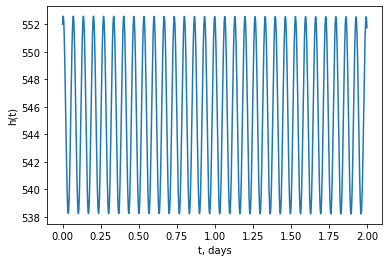

In [11]:
altitudes = []
for i in positions:
    alt = i.norm() - Earth.R
    altitudes.append(alt.value)

plt.ylabel("h(t)")
plt.xlabel("t, days")
plt.plot(tofs.value, altitudes)

In [12]:
import plotly.graph_objs as go
fig = go.Figure()

r = Earth.R.to(u.km).value

fig.add_trace(go.Line(x = tofs.value, y = altitudes, mode="markers", name="altitude [km]"))
fig.show()

# Update legend to show at the top
#fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1), 
#                  xaxis_title="Time [days]", yaxis_title="Altitude [km]", title="Atmosferic Drag ()",
#                  margin=dict(l=20, r=20, t=20, b=20))


/home/thomson/devel/perylune/venv/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


